<a href="https://colab.research.google.com/github/MariGaS/Proyecto_Tecnologico/blob/main/BOW_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import scipy.sparse as sp
from time import time
import numpy as np
import os
import re
from os import listdir
from os.path import isfile, join


In [2]:
from sklearn import svm 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score

#Depression 2022


## Using xlm.etree for text extration

In [3]:
import xml.etree.ElementTree as ET #library for read xml archives 

In [4]:
tree = ET.parse('/content/drive/MyDrive/Proyecto_Tecnologico/Data/depression2022/training data/2017 cases/pos/test_subject1345.xml') #we defined the tree with the archive, this command parse the .xml

In [5]:
root = tree.getroot() #obtained the root of the archive, root[0] correspond to the id user , root[1], root[2], etc correspond to WRITING tag

In [6]:
root[22][3].text #for each writing tag we can acces to the text indexing the writinig like root[i][3].text

' BRYCE MVP CONFIRMED  '

In [7]:
hist_post = [] # list with entries from the user 

#iterate recursively over all the sub-tree 
#source : https://docs.python.org/3/library/xml.etree.elementtree.html
for post in root.iter('TEXT'): 
    entry = post.text
    entry = entry.replace('\n', ' ') 
    entry = entry.replace("\'","'") 

    if entry == ' ' or entry == '  ':
        continue 
    else: 
        hist_post.append(entry[1:-1])

In [8]:
all_post = " " #concatenate all post 
for i in range(len(hist_post)):
    all_post = all_post + hist_post[i] + " "

In [9]:
all_post

' So many unwanted Smith fadeaways. Hey guys, Celtics fan here pulling hard for the Rockets to win it all. Huge Harden fan. I\'m wondering if anybody has a stat of how many total mid range jumpers the Rockets took during the regular season. I know they don\'t take many, even less before Josh Smith, but if anybody has the total that\'d be sweet. Go Rockets! Well he got 2 tonight so maybe he\'ll be able to scrape together some AB\'s. I agree with you though I mean he\'ll get pinch hits and an occasional day but I\'m afraid he\'s gonna lose his swing or something Yeah you\'re probably right. Oh well.  I guess that\'s true. You make a valid point but he\'s just watching. he\'s not going to get any playing time with our core back and healthy and playing so well, I would just rather him stay hot and keep hitting. I just think I\'d rather have him getting everyday at bats instead of sitting on our bench with Clint Robinson and Danny. I\'d rather him getting the consistent at bats even if it i

# Concatenate posts for users in Depression 2022

In [10]:
def get_urls(path): 
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    onlyfiles.sort()

    return onlyfiles

In [11]:
def get_text_post_train(user_path):
    tree = ET.parse(user_path)
    root = tree.getroot()
    hist_post = [] # list with entries from the user 

    #iterate recursively over all the sub-tree 
    #source : https://docs.python.org/3/library/xml.etree.elementtree.html
    for post in root.iter('TEXT'): 
        entry = post.text
        entry = entry.replace('\n', ' ') 

        if entry == ' ' or entry == '  ':
            continue 
        else: 
            hist_post.append(entry[1:-1])
    
    ##--------concatenate post -------------#
    all_post = "" #concatenate all post 
    for i in range(len(hist_post)):
        all_post = all_post + hist_post[i] + " "
    
    return all_post 

In [12]:
def get_text_labels(path, polarity = 'Negative'): 
    all_documents = [] #list with all the documents 
    all_label = [] #label 

    user_path = get_urls(path)
    for i in range(len(user_path)): 
        subject = user_path[i] #for example test_subjet1005.xml 
        path_subject = path + '/' + subject 
        document = get_text_post_train(path_subject) #get document with all the history of a user 

        all_documents += [document] 
        if polarity == 'Negative' : 
            all_label += [0]
        else: 
            all_label += [1]

    return all_documents, all_label 




In [13]:
train_neg_2017 = '/content/drive/MyDrive/Proyecto_Tecnologico/Data/depression2022/training data/2017 cases/neg'
train_pos_2017 = '/content/drive/MyDrive/Proyecto_Tecnologico/Data/depression2022/training data/2017 cases/pos'
train_neg_2018 = '/content/drive/MyDrive/Proyecto_Tecnologico/Data/depression2022/training data/2018 cases/neg'
train_pos_2018 = '/content/drive/MyDrive/Proyecto_Tecnologico/Data/depression2022/training data/2018 cases/pos'

In [14]:
tr_neg_2017, tr_lab_2017 = get_text_labels(train_neg_2017, polarity= 'Negative')

In [15]:
tr_pos_2017, tr_lab_pos_2017 = get_text_labels(train_pos_2017, polarity= 'Pos')

In [16]:
tr_neg_2018, tr_lab_2018 = get_text_labels(train_neg_2018, polarity= 'Negative')
tr_pos_2018, tr_lab_pos_2018 = get_text_labels(train_pos_2018, polarity= 'Pos')

### All training data 2017 

In [17]:
tr_txt_2017 = [*tr_neg_2017, *tr_pos_2017] 
tr_y_2017   = [*tr_lab_2017, *tr_lab_pos_2017]

### All training data 2018 

In [18]:
tr_txt_2018 = [*tr_neg_2018, *tr_pos_2018] 
tr_y_2018   = [*tr_lab_2018, *tr_lab_pos_2018]

Counter({0: 752, 1: 135})


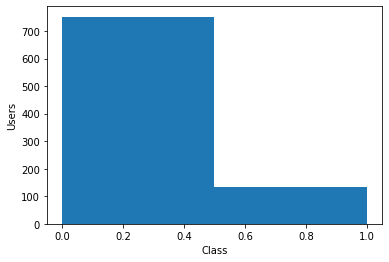

In [19]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y_2017))
plt.hist(tr_y_2017, bins=len(set(tr_y_2017)))
plt.ylabel('Users');
plt.xlabel('Class');

Counter({0: 741, 1: 79})


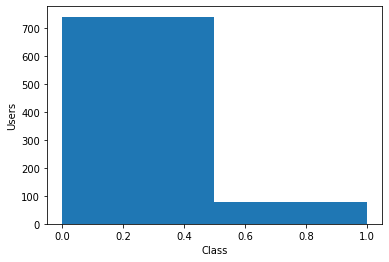

In [20]:
print(Counter(tr_y_2018))
plt.hist(tr_y_2018, bins=len(set(tr_y_2018)))
plt.ylabel('Users');
plt.xlabel('Class');

#Constructing BOW

In [21]:
def normalize(document): 

    document = [re.sub(r'https?:\/\/\S+', '', x) for x in document] #eliminate url
    document = [re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x) for x in document] #eliminate url 
    document = [re.sub(r'{link}', '', x) for x in document] #eliminate link
    document = [re.sub(r"\[video\]", '', x) for x in document] #eliminate video 
    document = [re.sub(r'\s+', ' ' '', x).strip() for x in document]
    document = [x.replace("#","") for x in document]  #eliminate #
    document = [re.subn(r'[^\w\s,]',"", x)[0].strip() for x in document] #eliminate emoticons 

    return document

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

In [23]:
def building_bow(data, labels,ntrain, min = 1, max = 1, num_feat = 3000, binary = False, tf= False, tf_idf = False, 
                 norm = False, stopwords = False, verbose = True, analyzer_char = False):
    documents = data 
    if norm == True:
        documents = normalize(documents)

    #split the data
    #x_train, x_val, y_train, y_val = train_test_split(documents, labels, test_size= split, random_state=42)
    x_train = documents[:ntrain]
    x_val   = documents[ntrain:]
    y_train = labels[:ntrain] 
    t_initial = time()

    analyzer_type = 'word' #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    if analyzer_char == True:
        analyzer_type = 'char' 

    if binary == True: 
        vectorizer = CountVectorizer(ngram_range=(min,max),binary=True)
    elif stopwords == True: 
        vectorizer = TfidfVectorizer(ngram_range=(min,max),stop_words='english',
                                     analyzer=analyzer_type,sublinear_tf=True)
    else: 
        vectorizer = TfidfVectorizer(ngram_range=(min,max),sublinear_tf=True,analyzer=analyzer_type)

    X_train = vectorizer.fit_transform(x_train)
    X_val = vectorizer.transform(x_val)
    
    if tf == True: 
        pipe = Pipeline([('count', CountVectorizer(ngram_range=(min,max),binary=True)),             
        ('tfid', TfidfTransformer(use_idf = False))]).fit(x_train)

        
        X_train = pipe['count'].transform(x_train).toarray()

        pipe = Pipeline([('count', CountVectorizer(ngram_range=(min,max),binary=True)),             
        ('tfid', TfidfTransformer(use_idf = False))]).fit(x_val)
        X_val =  pipe['count'].transform(x_val).toarray()

    if verbose:
        print("done in %fs" % (time() - t_initial), X_train.shape, X_val.shape)
    
    y = np.array(y_train) 
   
    
    if num_feat < X_train.shape[1]:
        t0 = time()
        ch2 = SelectKBest(chi2, k=num_feat)
        X_train = ch2.fit_transform(X_train, y)
        X_test = ch2.transform(X_val)
        assert sp.issparse(X_train)        

    if verbose:
        print("Extracting best features by a chi-squared test.. ", X_train.shape, X_test.shape)
    return X_train, y, X_test


## Experiments, test data : 2018

In [24]:
train = tr_txt_2017
test  = tr_txt_2018

labels = tr_y_2017

data = train +test 
ntrain = len(train)

t0 = time()


In [25]:
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight = 'balanced')
grid_depression = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs = 8, scoring = 'f1_macro', cv = 5)

### Experiment 1

In [26]:
x_train1,y_train1, x_test1 = building_bow(data, labels, ntrain, 1,1,3500, binary = True, norm = True, verbose = True)

done in 20.936725s (887, 221702) (820, 221702)
Extracting best features by a chi-squared test..  (887, 3500) (820, 3500)


In [27]:
grid_depression.fit(x_train1, y_train1)

y_pred = grid_depression.predict(x_test1)

b1 = grid_depression.best_params_
print("Best parameter: ",b1)

p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred))
print(metrics.classification_report(tr_y_2018,y_pred))



[p,r,f]

Best parameter:  {'C': 0.05}
[[716  25]
 [ 41  38]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       741
           1       0.60      0.48      0.54        79

    accuracy                           0.92       820
   macro avg       0.77      0.72      0.75       820
weighted avg       0.91      0.92      0.92       820



[0.7745067203455578, 0.7236372332974599, 0.7455762613061546]

### Experiment 2 

In [28]:
x_train2,y_train2, x_test2 = building_bow(data, labels, ntrain, 1,1,3200, tf_idf = True, norm = True, verbose = True)


done in 20.983032s (887, 221702) (820, 221702)
Extracting best features by a chi-squared test..  (887, 3200) (820, 3200)


In [29]:
grid_depression.fit(x_train2, y_train2)

y_pred2 = grid_depression.predict(x_test2)
b2 = grid_depression.best_params_
print("Best parameter: ", b2)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred2, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred2))
print(metrics.classification_report(tr_y_2018,y_pred2))

[p,r,f]


Best parameter:  {'C': 1}
[[713  28]
 [ 34  45]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       741
           1       0.62      0.57      0.59        79

    accuracy                           0.92       820
   macro avg       0.79      0.77      0.78       820
weighted avg       0.92      0.92      0.92       820



[0.7854614806256992, 0.7659167392678385, 0.7752192982456141]

### Experiment 3

In [30]:
x_train3,y_train3, x_test3 = building_bow(data, labels, ntrain, 1,1,100, stopwords = True, norm = True, verbose = True)

done in 20.716018s (887, 221389) (820, 221389)
Extracting best features by a chi-squared test..  (887, 100) (820, 100)


In [31]:
grid_depression.fit(x_train3, y_train3)

y_pred3 = grid_depression.predict(x_test3)
b3 = grid_depression.best_params_
print("Best parameter: ", b3)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred3, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred3))
print(metrics.classification_report(tr_y_2018,y_pred3))

[p,r,f]

Best parameter:  {'C': 2}
[[706  35]
 [ 25  54]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       741
           1       0.61      0.68      0.64        79

    accuracy                           0.93       820
   macro avg       0.79      0.82      0.80       820
weighted avg       0.93      0.93      0.93       820



[0.7862709233157595, 0.8181554177556842, 0.8010481366459627]

### Experiment 4

In [32]:
x_train4,y_train4, x_test4 = building_bow(data, labels, ntrain, 2,2,3000, stopwords = True, norm = True, verbose = True)
grid_depression.fit(x_train4, y_train4)

y_pred4 = grid_depression.predict(x_test4)
b4 = grid_depression.best_params_
print("Best parameter: ", b4)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred4, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred4))
print(metrics.classification_report(tr_y_2018,y_pred4))

[p,r,f]

done in 58.428690s (887, 3794417) (820, 3794417)
Extracting best features by a chi-squared test..  (887, 3000) (820, 3000)
Best parameter:  {'C': 4}
[[708  33]
 [ 28  51]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       741
           1       0.61      0.65      0.63        79

    accuracy                           0.93       820
   macro avg       0.78      0.80      0.79       820
weighted avg       0.93      0.93      0.93       820



[0.7845496894409938, 0.8005176036488495, 0.7922334694352255]

### Experiment 5

In [33]:
x_train5,y_train5, x_test5 = building_bow(data, labels, ntrain, 2,2,3000, binary = True, norm = True, verbose = True)
grid_depression.fit(x_train5, y_train5)

y_pred5 = grid_depression.predict(x_test5)
b5 = grid_depression.best_params_
print("Best parameter: ", b5)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred5, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred5))
print(metrics.classification_report(tr_y_2018,y_pred5))

[p,r,f]

done in 62.532229s (887, 3165625) (820, 3165625)
Extracting best features by a chi-squared test..  (887, 3000) (820, 3000)
Best parameter:  {'C': 0.25}
[[692  49]
 [ 46  33]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.94       741
           1       0.40      0.42      0.41        79

    accuracy                           0.88       820
   macro avg       0.67      0.68      0.67       820
weighted avg       0.89      0.88      0.89       820



[0.6700542005420054, 0.675797331693401, 0.6728526493055993]

### Experiment 6

In [34]:
x_train6,y_train6, x_test6 = building_bow(data, labels, ntrain, 2,2,500, tf_idf = True, norm = True, verbose = True)
grid_depression.fit(x_train6, y_train6)

y_pred6 = grid_depression.predict(x_test6)
b6 = grid_depression.best_params_
print("Best paramter: ", b6)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred6, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred6))
print(metrics.classification_report(tr_y_2018,y_pred6))

[p,r,f]

done in 92.782883s (887, 3165625) (820, 3165625)
Extracting best features by a chi-squared test..  (887, 500) (820, 500)
Best paramter:  {'C': 4}
[[700  41]
 [ 28  51]]
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       741
           1       0.55      0.65      0.60        79

    accuracy                           0.92       820
   macro avg       0.76      0.80      0.77       820
weighted avg       0.92      0.92      0.92       820



[0.7579431438127091, 0.7951194929875809, 0.774760249841759]

### Experiment 7

In [71]:
x_train7,y_train7, x_test7 = building_bow(data, labels, ntrain, 1,2,500, tf_idf = True, norm = True, verbose = True)
grid_depression.fit(x_train7, y_train7)

y_pred7 = grid_depression.predict(x_test7)
b7 = grid_depression.best_params_
print("Best paramter: ", b7)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred7, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred7))
print(metrics.classification_report(tr_y_2018,y_pred7))

[p,r,f]

done in 88.230246s (887, 3387327) (820, 3387327)
Extracting best features by a chi-squared test..  (887, 500) (820, 500)
Best paramter:  {'C': 2}
[[710  31]
 [ 28  51]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       741
           1       0.62      0.65      0.63        79

    accuracy                           0.93       820
   macro avg       0.79      0.80      0.80       820
weighted avg       0.93      0.93      0.93       820



[0.7920054200542006, 0.8018671313141666, 0.7968242769371617]

### Experiment 8 

In [82]:
x_train8,y_train8, x_test8 = building_bow(data, labels, ntrain, 1,3,1500, tf_idf = True, norm = True, verbose = True)
grid_depression.fit(x_train8, y_train8)

y_pred8 = grid_depression.predict(x_test8)
b8 = grid_depression.best_params_
print("Best paramter: ", b8)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred8, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred8))
print(metrics.classification_report(tr_y_2018,y_pred8))

[p,r,f]

done in 395.372621s (887, 11732715) (820, 11732715)
Extracting best features by a chi-squared test..  (887, 1500) (820, 1500)
Best paramter:  {'C': 2}
[[696  45]
 [ 24  55]]
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       741
           1       0.55      0.70      0.61        79

    accuracy                           0.92       820
   macro avg       0.76      0.82      0.78       820
weighted avg       0.93      0.92      0.92       820



[0.7583333333333333, 0.8177368933531493, 0.7836486067933879]

### Experiment 9 

In [81]:
x_train9,y_train9, x_test9 = building_bow(data, labels, ntrain, 2,3,50, tf_idf = True, norm = True, verbose = True)
grid_depression.fit(x_train9, y_train9)

y_pred9 = grid_depression.predict(x_test9)
b9 = grid_depression.best_params_
print("Best paramter: ", b9)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred9, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred9))
print(metrics.classification_report(tr_y_2018,y_pred9))

[p,r,f]

done in 313.988091s (887, 11511013) (820, 11511013)
Extracting best features by a chi-squared test..  (887, 50) (820, 50)
Best paramter:  {'C': 2}
[[690  51]
 [ 27  52]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       741
           1       0.50      0.66      0.57        79

    accuracy                           0.90       820
   macro avg       0.73      0.79      0.76       820
weighted avg       0.92      0.90      0.91       820



[0.7335987325831742, 0.7947009685850459, 0.75896531452087]

### Experiment 10

In [85]:
x_train10,y_train10, x_test10 = building_bow(data, labels, ntrain, 1,2,2500, stopwords = True, norm = True, verbose = True)
grid_depression.fit(x_train10, y_train10)

y_pred10 = grid_depression.predict(x_test10)
b10 = grid_depression.best_params_
print("Best paramter: ", b10)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred10, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred10))
print(metrics.classification_report(tr_y_2018,y_pred10))

[p,r,f]

done in 114.813317s (887, 4015806) (820, 4015806)
Extracting best features by a chi-squared test..  (887, 2500) (820, 2500)
Best paramter:  {'C': 4}
[[690  51]
 [ 20  59]]
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       741
           1       0.54      0.75      0.62        79

    accuracy                           0.91       820
   macro avg       0.75      0.84      0.79       820
weighted avg       0.93      0.91      0.92       820



[0.7540973111395647, 0.8390047660534004, 0.7877034265731715]

### Experiment 11

In [102]:
x_train11,y_train11, x_test11 = building_bow(data, labels, ntrain, 1,3,4000, stopwords = True, norm = True, verbose = True)
grid_depression.fit(x_train11, y_train11)

y_pred11 = grid_depression.predict(x_test11)
b11 = grid_depression.best_params_
print("Best paramter: ", b11)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred11, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred11))
print(metrics.classification_report(tr_y_2018,y_pred11))

[p,r,f]

done in 218.159567s (887, 9931300) (820, 9931300)
Extracting best features by a chi-squared test..  (887, 4000) (820, 4000)
Best paramter:  {'C': 4}
[[629 112]
 [ 13  66]]
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       741
           1       0.37      0.84      0.51        79

    accuracy                           0.85       820
   macro avg       0.68      0.84      0.71       820
weighted avg       0.92      0.85      0.87       820



[0.675268647835066, 0.842147969729582, 0.711617726084669]

### Experiment 12

In [101]:

x_train12,y_train12, x_test12 = building_bow(data, labels, ntrain, 2,3,4000, stopwords = True, norm = True, verbose = True)
grid_depression.fit(x_train12, y_train12)

y_pred12 = grid_depression.predict(x_test12)
b12 = grid_depression.best_params_
print("Best paramter: ", b12)
p , r, f, _ = precision_recall_fscore_support(tr_y_2018, y_pred12, average = 'macro', pos_label = 1)

print(confusion_matrix(tr_y_2018, y_pred12))
print(metrics.classification_report(tr_y_2018,y_pred12))

[p,r,f]

done in 183.319699s (887, 9709911) (820, 9709911)
Extracting best features by a chi-squared test..  (887, 4000) (820, 4000)
Best paramter:  {'C': 4}
[[649  92]
 [ 17  62]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       741
           1       0.40      0.78      0.53        79

    accuracy                           0.87       820
   macro avg       0.69      0.83      0.73       820
weighted avg       0.92      0.87      0.88       820



[0.6885359385359385, 0.8303267906865508, 0.7273595236570062]

#Anorexia 

In [35]:
anxia_test = '/content/drive/MyDrive/Proyecto_Tecnologico/Data/Anorexia Datasets_1/test'
anxia_train = '/content/drive/MyDrive/Proyecto_Tecnologico/Data/Anorexia Datasets_1/train'

## Get training data

In [36]:
def get_text_chunk(path): 
    all_documents = [] #list with all the documents 
    all_label = [] #label 

    user_path = get_urls(path)
    for i in range(len(user_path)): 
        subject = user_path[i] #for example test_subjet1005.xml 
        path_subject = path + '/' + subject 
        document = get_text_post_train(path_subject) #get document with all the history of a user 

        all_documents += [document] 
    return all_documents




In [37]:
pos = 'positive_examples'
neg = 'negative_examples'

all_pos = []
all_neg = []
for i in range(1,11):
    path_chunk_pos = anxia_train +'/' + pos + '/chunk'+str(i)
    path_chunk_neg = anxia_train +'/' + neg + '/chunk'+str(i)

    temp1 = get_text_chunk(path_chunk_pos)
    temp2 = get_text_chunk(path_chunk_neg)
    if i == 1: 
        all_pos = temp1
        all_neg = temp2
    else: 
        for j in range(len(temp1)):
            all_pos[j] += temp1[j]
    
        for j in range(len(temp2)):
            all_neg[j] += temp2[j]
    

In [38]:
tr_anorexia = [*all_pos, *all_neg]

In [39]:
len(get_urls('/content/drive/MyDrive/Proyecto_Tecnologico/Data/Anorexia Datasets_1/train/negative_examples/chunk1'))

132

In [40]:
tr_label = []
for i in range(len(tr_anorexia)):
    if i < 20: 
        tr_label.append(1)
    else:
        tr_label.append(0)

## Get test data

In [41]:
test_url_anxia   = []
test_labels_anxia = []

with open('/content/drive/MyDrive/Proyecto_Tecnologico/Data/Anorexia Datasets_1/test/test_golden_truth.txt') as f:
    lines = f.readlines()
    for line in lines: 

        test_url_anxia.append(line[:-3]) #only the name of the subject 

        test_labels_anxia.append(int(line[-2:-1])) #only the label
    f.close()

In [42]:
def get_text_test_anorexia(path, list_subject, chunk): 
    all_documents = [] #list with all the documents 
    all_label = [] #label 

    for i in range(len(list_subject)): 
        subject = list_subject[i] #for example test_subjet1005.xml 
        path_subject = path + '/chunk'+ str(chunk) + '/' + subject + '_' + str(chunk) + '.xml'
        
        document = get_text_post_train(path_subject) #get document with all the history of a user 
        
        all_documents += [document] 
    print("text extracted for all users")
    return all_documents

In [43]:
test_anxia = []
for i in range(1,11):

    temp1 = get_text_test_anorexia(anxia_test, test_url_anxia, i)

    if i == 1: 
        test_anxia = temp1
        print("Text extracted from chunk: ", i)
    else: 

        for j in range(len(temp1)):
            test_anxia[j] += temp1[j]
        print("Text extracted from chunk: ", i)

text extracted for all users
Text extracted from chunk:  1
text extracted for all users
Text extracted from chunk:  2
text extracted for all users
Text extracted from chunk:  3
text extracted for all users
Text extracted from chunk:  4
text extracted for all users
Text extracted from chunk:  5
text extracted for all users
Text extracted from chunk:  6
text extracted for all users
Text extracted from chunk:  7
text extracted for all users
Text extracted from chunk:  8
text extracted for all users
Text extracted from chunk:  9
text extracted for all users
Text extracted from chunk:  10


##Experiment

In [44]:
train_anxia = tr_anorexia
test_anxia  = test_anxia

labels_anxia = tr_label

data_anxia = train_anxia + test_anxia
ntrain_anxia = len(train_anxia)

t0 = time()



In [45]:
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight = 'balanced')
grid_anorexia = GridSearchCV(estimator = svr, param_grid = parameters, n_jobs = 8, scoring = 'f1_macro', cv = 5)



In [46]:
x_train_anxia1,y_anxia_1, x_test_anxia1 = building_bow(data_anxia,  labels_anxia, ntrain_anxia, 1,1,4000, 
                                                     binary = True, norm = True, verbose = True)

done in 4.323384s (152, 72757) (320, 72757)
Extracting best features by a chi-squared test..  (152, 4000) (320, 4000)


### Experiment 1

In [47]:
grid_anorexia.fit(x_train_anxia1, y_anxia_1)

y_pred_anxia1 = grid_anorexia.predict(x_test_anxia1)
a1 = grid_anorexia.best_params_
print("Best paramter: ", a1)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia1, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia1))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia1))



[p,r,f]

Best paramter:  {'C': 0.05}
[[276   3]
 [ 25  16]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       279
           1       0.84      0.39      0.53        41

    accuracy                           0.91       320
   macro avg       0.88      0.69      0.74       320
weighted avg       0.91      0.91      0.90       320



[0.8795243923762895, 0.6897456071334906, 0.7425287356321839]

### Experiment 2

In [48]:
x_train_anxia2,y_anxia_2, x_test_anxia2 = building_bow(data_anxia,  labels_anxia, ntrain_anxia, 1,1,2000, 
                                                     tf_idf = True, norm = True, verbose = True)


done in 4.399583s (152, 72757) (320, 72757)
Extracting best features by a chi-squared test..  (152, 2000) (320, 2000)


In [49]:
grid_anorexia.fit(x_train_anxia2, y_anxia_2)

y_pred_anxia2 = grid_anorexia.predict(x_test_anxia2)
a2 = grid_anorexia.best_params_
print("Best paramter: ", a2)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia2, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia2))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia2))
[p,r,f]


Best paramter:  {'C': 0.05}
[[277   2]
 [ 13  28]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       279
           1       0.93      0.68      0.79        41

    accuracy                           0.95       320
   macro avg       0.94      0.84      0.88       320
weighted avg       0.95      0.95      0.95       320



[0.9442528735632184, 0.8378791852434654, 0.881185177850937]

### Experiment 3

In [50]:
x_train_anxia3,y_anxia_3, x_test_anxia3 = building_bow(data_anxia, labels_anxia, ntrain_anxia,
                                                     1,1,1400, stopwords = True, norm = True, verbose = True) #1400-2000 words has the same results 


done in 4.143907s (152, 72449) (320, 72449)
Extracting best features by a chi-squared test..  (152, 1400) (320, 1400)


In [51]:
grid_anorexia.fit(x_train_anxia3, y_anxia_3)

y_pred_anxia3 = grid_anorexia.predict(x_test_anxia3)
a3 = grid_anorexia.best_params_
print("Best paramter: ", a3)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia3, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia3))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia3))
[p,r,f]

Best paramter:  {'C': 0.05}
[[277   2]
 [ 13  28]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       279
           1       0.93      0.68      0.79        41

    accuracy                           0.95       320
   macro avg       0.94      0.84      0.88       320
weighted avg       0.95      0.95      0.95       320



[0.9442528735632184, 0.8378791852434654, 0.881185177850937]

### Experiment 4

In [52]:
x_train_anxia4,y_anxia_4, x_test_anxia4= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    2,2,1200, tf_idf = True, norm = True, verbose = True)


done in 12.989903s (152, 797263) (320, 797263)
Extracting best features by a chi-squared test..  (152, 1200) (320, 1200)


In [53]:
grid_anorexia.fit(x_train_anxia4, y_anxia_4)

y_pred_anxia4 = grid_anorexia.predict(x_test_anxia4)
a4 = grid_anorexia.best_params_
print("Best paramter: ", a4)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia4, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia4))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia4))
[p,r,f]

Best paramter:  {'C': 4}
[[278   1]
 [ 20  21]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       279
           1       0.95      0.51      0.67        41

    accuracy                           0.93       320
   macro avg       0.94      0.75      0.82       320
weighted avg       0.94      0.93      0.93       320



[0.9437156802928615, 0.7543054462802692, 0.8151357596764877]

### Experiment 5

In [54]:
x_train_anxia5,y_anxia_5, x_test_anxia5= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    2,2,1500, binary = True, norm = True, verbose = True)

done in 12.327697s (152, 797263) (320, 797263)
Extracting best features by a chi-squared test..  (152, 1500) (320, 1500)


In [55]:

grid_anorexia.fit(x_train_anxia5, y_anxia_5)

y_pred_anxia5 = grid_anorexia.predict(x_test_anxia5)
a5 = grid_anorexia.best_params_
print("Best paramter: ", a5)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia5, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia5))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia5))
[p,r,f]

Best paramter:  {'C': 4}
[[276   3]
 [ 22  19]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       279
           1       0.86      0.46      0.60        41

    accuracy                           0.92       320
   macro avg       0.89      0.73      0.78       320
weighted avg       0.92      0.92      0.91       320



[0.8949054301403294, 0.7263309729871492, 0.77992352342439]

### Experiment 6

In [56]:
x_train_anxia6,y_anxia_6, x_test_anxia6= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    1,2,1200, binary = True, norm = True, verbose = True)

done in 15.673727s (152, 870020) (320, 870020)
Extracting best features by a chi-squared test..  (152, 1200) (320, 1200)


In [57]:

grid_anorexia.fit(x_train_anxia6, y_anxia_6)

y_pred_anxia6 = grid_anorexia.predict(x_test_anxia6)
a6 = grid_anorexia.best_params_
print("Best paramter: ", a6)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia6, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia6))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia6))

[p,r,f]

Best paramter:  {'C': 4}
[[277   2]
 [ 22  19]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       279
           1       0.90      0.46      0.61        41

    accuracy                           0.93       320
   macro avg       0.92      0.73      0.79       320
weighted avg       0.92      0.93      0.91       320



[0.9155916547220895, 0.7281230876824898, 0.7856903672284854]

### Experiment  7

In [58]:
x_train_anxia7,y_anxia_7, x_test_anxia7= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    1,2,1500, tf_idf = True, norm = True, verbose = True)

done in 16.056752s (152, 870020) (320, 870020)
Extracting best features by a chi-squared test..  (152, 1500) (320, 1500)


In [59]:

grid_anorexia.fit(x_train_anxia7, y_anxia_7)

y_pred_anxia7 = grid_anorexia.predict(x_test_anxia7)
a7 = grid_anorexia.best_params_
print("Best paramter: ", a7)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia7, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia7))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia7))

[p,r,f]

Best paramter:  {'C': 4}
[[276   3]
 [ 15  26]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       279
           1       0.90      0.63      0.74        41

    accuracy                           0.94       320
   macro avg       0.92      0.81      0.86       320
weighted avg       0.94      0.94      0.94       320



[0.9225026661926768, 0.8116968266456859, 0.8556390977443609]

### Experiment 8

In [60]:
x_train_anxia8,y_anxia_8, x_test_anxia8= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    1,3,1500, tf_idf = True, norm = True, verbose = True)


grid_anorexia.fit(x_train_anxia8, y_anxia_8)

y_pred_anxia8 = grid_anorexia.predict(x_test_anxia8)
a8 = grid_anorexia.best_params_
print("Best paramter: ", a8)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia8, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia8))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia8))

[p,r,f]

done in 35.530946s (152, 2561230) (320, 2561230)
Extracting best features by a chi-squared test..  (152, 1500) (320, 1500)
Best paramter:  {'C': 4}
[[275   4]
 [ 11  30]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       279
           1       0.88      0.73      0.80        41

    accuracy                           0.95       320
   macro avg       0.92      0.86      0.89       320
weighted avg       0.95      0.95      0.95       320



[0.9219457013574661, 0.8586851997552234, 0.8867256637168142]

### Experiment 9

In [61]:
x_train_anxia9,y_anxia_9, x_test_anxia9= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    1,3,1500, binary= True, norm = True, verbose = True)


grid_anorexia.fit(x_train_anxia9, y_anxia_9)

y_pred_anxia9 = grid_anorexia.predict(x_test_anxia9)
a9 = grid_anorexia.best_params_
print("Best paramter: ", a9)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia9, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia9))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia9))

[p,r,f]

done in 32.485133s (152, 2561230) (320, 2561230)
Extracting best features by a chi-squared test..  (152, 1500) (320, 1500)
Best paramter:  {'C': 0.05}
[[276   3]
 [ 23  18]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       279
           1       0.86      0.44      0.58        41

    accuracy                           0.92       320
   macro avg       0.89      0.71      0.77       320
weighted avg       0.91      0.92      0.91       320



[0.8901098901098901, 0.7141358510359297, 0.7678312311641924]

### Experiment 10

In [62]:
x_train_anxia10,y_anxia_10, x_test_anxia10= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    2,3,1500, binary= True, norm = True, verbose = True)


grid_anorexia.fit(x_train_anxia10, y_anxia_10)

y_pred_anxia10 = grid_anorexia.predict(x_test_anxia10)
a10 = grid_anorexia.best_params_
print("Best paramter: ", a10)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia10, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia10))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia10))

[p,r,f]

done in 30.543480s (152, 2488473) (320, 2488473)
Extracting best features by a chi-squared test..  (152, 1500) (320, 1500)
Best paramter:  {'C': 0.12}
[[277   2]
 [ 25  16]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       279
           1       0.89      0.39      0.54        41

    accuracy                           0.92       320
   macro avg       0.90      0.69      0.75       320
weighted avg       0.91      0.92      0.90       320



[0.9030537159676233, 0.6915377218288312, 0.7479506403337322]

### Experiment 11

In [63]:
x_train_anxia11,y_anxia_11, x_test_anxia11= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    2,3,1500, tf_idf= True, norm = True, verbose = True)


grid_anorexia.fit(x_train_anxia11, y_anxia_11)

y_pred_anxia11 = grid_anorexia.predict(x_test_anxia11)
a11 = grid_anorexia.best_params_
print("Best paramter: ", a11)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia11, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia11))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia11))

[p,r,f]

done in 30.993291s (152, 2488473) (320, 2488473)
Extracting best features by a chi-squared test..  (152, 1500) (320, 1500)
Best paramter:  {'C': 4}
[[277   2]
 [ 17  24]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       279
           1       0.92      0.59      0.72        41

    accuracy                           0.94       320
   macro avg       0.93      0.79      0.84       320
weighted avg       0.94      0.94      0.93       320



[0.9326268969126112, 0.7890986974385873, 0.841629548592118]

### Experiment 12

In [64]:
x_train_anxia12,y_anxia_12, x_test_anxia12= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    1,2,1500, stopwords = True, norm = True, verbose = True)


grid_anorexia.fit(x_train_anxia12, y_anxia_12)

y_pred_anxia12 = grid_anorexia.predict(x_test_anxia12)
a12 = grid_anorexia.best_params_
print("Best paramter: ", a12)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia12, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia12))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia12))

[p,r,f]

done in 11.761235s (152, 869738) (320, 869738)
Extracting best features by a chi-squared test..  (152, 1500) (320, 1500)
Best paramter:  {'C': 4}
[[276   3]
 [ 10  31]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       279
           1       0.91      0.76      0.83        41

    accuracy                           0.96       320
   macro avg       0.94      0.87      0.90       320
weighted avg       0.96      0.96      0.96       320



[0.9383998354586589, 0.8726724364017834, 0.9018289085545722]

### Experiment 13

In [65]:
x_train_anxia13,y_anxia_13, x_test_anxia13= building_bow(data_anxia, labels_anxia, ntrain_anxia, 
                                                    2,3,1500, stopwords = True, norm = True, verbose = True)


grid_anorexia.fit(x_train_anxia13, y_anxia_13)

y_pred_anxia13 = grid_anorexia.predict(x_test_anxia13)
a13 = grid_anorexia.best_params_
print("Best paramter: ", a13)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, y_pred_anxia13, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia, y_pred_anxia13))
print(metrics.classification_report(test_labels_anxia,y_pred_anxia13))

[p,r,f]

done in 18.029520s (152, 1839157) (320, 1839157)
Extracting best features by a chi-squared test..  (152, 1500) (320, 1500)
Best paramter:  {'C': 4}
[[277   2]
 [ 16  25]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       279
           1       0.93      0.61      0.74        41

    accuracy                           0.94       320
   macro avg       0.94      0.80      0.85       320
weighted avg       0.94      0.94      0.94       320



[0.9356592086967513, 0.8012938193898068, 0.8519127930892637]

# Using tests data 2022, ONLY POST not using comments